# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune


___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
#import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
#dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = '/home/olivia/MothMachineLearning/dataAndFigs/Figs/'
dataOutput = '/home/olivia/MothMachineLearning/dataAndFigs/DataOutput/'
savedModels = '/home/olivia/MothMachineLearning/dataAndFigs/savedModels/'
dataDir = '/home/olivia/MothMachineLearning/dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 

last run on 2020-07-13 13:37:37.907519


In [2]:
tf.__version__

'1.15.0'

In [3]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [4]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "onetorqueData_small.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [5]:
con1 = sqlite3.connect(os.path.join(dataDir, "onetorqueData_small.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [6]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [7]:
print(trainDF.shape)
trainDF.head()

(10000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1487.085667,0.0,675.210986,0.283438,-6.447281,1.467734,-11.846045,27.839454,1464.704218,17.419847,1085.463464,-1.183080,-119.463296,0.132160,-112.498065,41181.992912,1.987846,-63216.237665
1,0.0,-659.642413,0.0,573.291475,3.710207,-5.406108,0.336900,20.346018,-12.940524,-630.528328,12.242467,640.306749,3.589540,-17.753963,0.399032,-8.758895,9062.020340,3.567122,19108.940596
2,0.0,-1459.147737,0.0,-534.961786,1.663134,20.700009,1.001656,-1.155835,-24.941150,-1644.837978,-8.502142,-227.265602,4.642282,302.438534,4.027007,302.393511,42727.993224,4.104033,49781.327507
3,0.0,610.529816,0.0,-483.934820,2.614529,-11.873466,1.080097,-20.678326,13.293185,768.009637,-7.702570,-294.059742,1.637712,-75.828597,0.137267,-74.333441,28953.145279,4.698031,92261.347215
4,0.0,942.511712,0.0,-512.218620,5.400776,8.669205,0.387209,-13.597169,19.059824,953.202671,-10.462695,-536.284710,4.915897,-22.529338,0.219076,-6.868852,371.601599,0.668810,-40259.257246


In [8]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [9]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [10]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [11]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,1.467734,0.283438,27.839454,17.419847,0.132160,-1.183080,1487.085667,675.210986,-11.846045,-6.447281
1,0.336900,3.710207,-12.940524,12.242467,0.399032,3.589540,-659.642413,573.291475,20.346018,-5.406108
2,1.001656,1.663134,-24.941150,-8.502142,4.027007,4.642282,-1459.147737,-534.961786,-1.155835,20.700009
3,1.080097,2.614529,13.293185,-7.702570,0.137267,1.637712,610.529816,-483.934820,-20.678326,-11.873466
4,0.387209,5.400776,19.059824,-10.462695,0.219076,4.915897,942.511712,-512.218620,-13.597169,8.669205


In [12]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,1464.704218,1085.463464,-112.498065,-119.463296
1,-8253.874132,-3740.825371,19108.940596,-630.528328,640.306749,-8.758895,-17.753963
2,-24419.876370,-35062.102662,49781.327507,-1644.837978,-227.265602,302.393511,302.438534
3,-415.702991,-28950.160838,92261.347215,768.009637,-294.059742,-74.333441,-75.828597
4,291.543841,230.412537,-40259.257246,953.202671,-536.284710,-6.868852,-22.529338


In [13]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [14]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [15]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.376257,-0.289051,-0.281519,-0.424879,0.235244,-0.076389,-0.316012,-0.477942,0.353820,-0.276983
1,0.459401,-0.247502,0.061181,0.327677,0.161407,-0.184346,0.045832,0.382379,-0.481258,0.089008
2,0.314432,0.386040,-0.412174,-0.253634,0.221174,0.254028,-0.461105,-0.231406,0.142344,-0.293662
3,0.368627,0.312315,-0.073352,-0.391641,0.085137,0.062939,-0.144471,-0.449930,-0.001804,0.284501
4,0.383340,-0.385124,0.168319,-0.349788,0.302716,-0.067995,0.210806,-0.374484,0.213629,-0.482080


# Keras models

In [16]:
# import
#from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
#from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Keras callcacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

K.clear_session()

In [17]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [18]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


earlystop = EarlyStopping(monitor='val_mse', patience=15, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [19]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

In [20]:
# train and trim weights

In [21]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_13__01_38_55
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               4400      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_4 (Dense)              (None, 7)       

In [22]:
model

In [23]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [24]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [25]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    verbose = 2, batch_size=2**12, epochs = 100)

#error with using earlystop

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 0s - loss: 0.1852 - mean_squared_error: 0.1852 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 2/100
8000/8000 - 0s - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 3/100
8000/8000 - 0s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 4/100
8000/8000 - 0s - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 5/100
8000/8000 - 0s - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6/100
8000/8000 - 0s - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 7/100
8000/8000 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 8/100
8000/8000 - 0s - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0268 -

Epoch 67/100
8000/8000 - 0s - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 68/100
8000/8000 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 69/100
8000/8000 - 0s - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 70/100
8000/8000 - 0s - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 71/100
8000/8000 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 72/100
8000/8000 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 73/100
8000/8000 - 0s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 74/100
8000/8000 - 0s - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 75

In [26]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


In [27]:
# save history
historyDict["mean_squared_error"].extend(history.history['mean_squared_error'])
historyDict["val_mean_squared_error"].extend(history.history['val_mean_squared_error'])

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


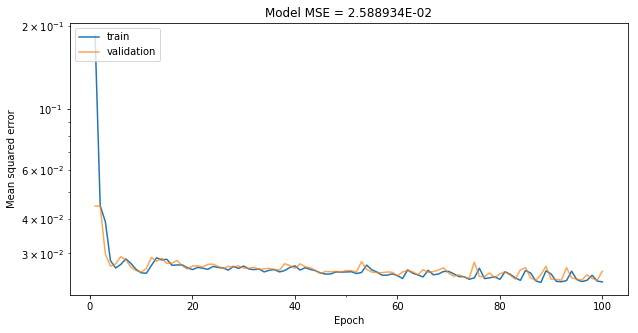

In [28]:
plot_model_history_fromDict(historyDict)

In [29]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

In [42]:
#  plot error rates on test data

In [43]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-3902.627197,13389.475586,-57320.773438,-625.664429,-1350.835938,-80.646065,-87.709602
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-5796.776855,5695.291992,-56892.628906,-30.198397,1201.666626,19.744678,4.836681
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-13899.515625,-16868.404297,-47959.855469,-1121.541992,-1492.698975,126.931892,117.343353
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,23925.521484,-8971.760742,64965.503906,-205.964630,-461.440735,103.438126,104.045082
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,3135.195068,3398.913574,29924.617188,724.535278,87.682320,-19.723558,-16.119921


In [44]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [45]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

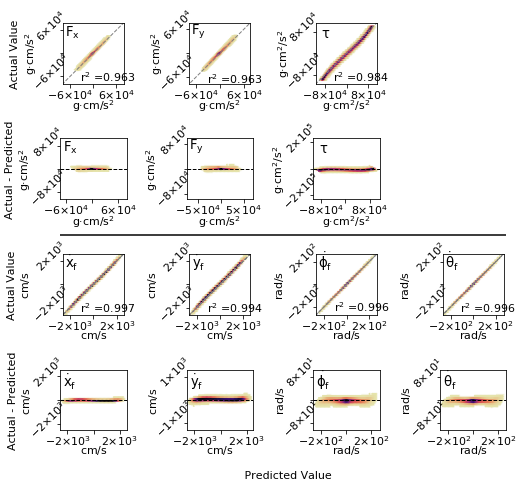

In [46]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

In [47]:
## Pruning
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_07__02_09_02'

In [21]:
# load model
from tensorflow.keras.models import load_model

K.clear_session()

modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_07__02_09_02"
modeltimestamp = "2020_07_07__02_09_02"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


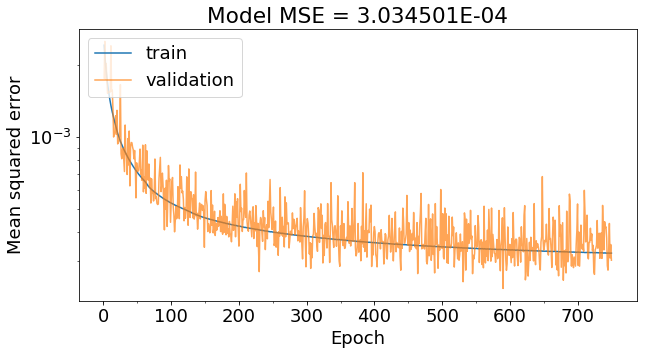

In [22]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

In [23]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [24]:


# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [25]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent*2)

[ 0.         15.86485043 30.95069212 44.62436102 56.48995528 66.40367703
 74.42768674 80.75689166 85.64849155 89.36977272 92.16685544 94.25030081
 95.7917306  96.92645889 97.75871874 98.36748577 98.81189556 99.1358533
 99.37175734 99.54340943 99.66823978 99.75898315 99.82492807 99.87284121
 99.90764768 99.93292997]


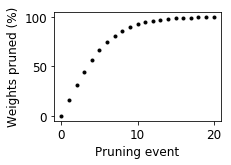

In [26]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

In [27]:
(cutPercent*2)[0:21]

array([ 0.        , 15.86485043, 30.95069212, 44.62436102, 56.48995528,
       66.40367703, 74.42768674, 80.75689166, 85.64849155, 89.36977272,
       92.16685544, 94.25030081, 95.7917306 , 96.92645889, 97.75871874,
       98.36748577, 98.81189556, 99.1358533 , 99.37175734, 99.54340943,
       99.66823978])

In [28]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mse"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mse"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mse"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                  q = (50 - cutPercent[numCuts], 
                                       50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mse"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                model.save(os.path.join(savedModels,  modelSubdir, modelName + str(overallEpochCounter) + '_Pruned.h5'))
                
                
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break

    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
#winsound.PlaySound("*", winsound.SND_ALIAS)

750
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2519e-04 - mse: 3.2519e-04 - val_loss: 3.0746e-04 - val_mse: 3.0746e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2525e-04 - mse: 3.2525e-04 - val_loss: 4.1877e-04 - val_mse: 4.1877e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2516e-04 - mse: 3.2516e-04 - val_loss: 3.2953e-04 - val_mse: 3.2953e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2488e-04 - mse: 3.2488e-04 - val_loss: 4.2382e-04 - val_mse: 4.2382e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2460e-04 - mse: 3.2460e-04 - val_loss: 3.3457e-04 - val_mse: 3.3457e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1

 - 12s - loss: 3.2467e-04 - mse: 3.2467e-04 - val_loss: 4.2679e-04 - val_mse: 4.2679e-04
111458 of 331735 weights retained
change in log loss: -0.001176929473877153
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2437e-04 - mse: 3.2437e-04 - val_loss: 5.5620e-04 - val_mse: 5.5620e-04
111458 of 331735 weights retained
change in log loss: -0.0006621360778811258
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2468e-04 - mse: 3.2468e-04 - val_loss: 3.5805e-04 - val_mse: 3.5805e-04
111458 of 331735 weights retained
change in log loss: -0.0006265640258792393
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2441e-04 - mse: 3.2441e-04 - val_loss: 3.5837e-04 - val_mse: 3.5837e-04
111458 of 331735 weights retained
change in log loss: -0.000244808197021662
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2431e-04 - mse: 3.2431e-04 - val_loss: 3.3960e-04 - val_mse: 3.39

84842 of 331735 weights retained
change in log loss: -0.0004176139831545411
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2629e-04 - mse: 3.2629e-04 - val_loss: 3.6662e-04 - val_mse: 3.6662e-04
84842 of 331735 weights retained
change in log loss: -0.0007703781127932352
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2590e-04 - mse: 3.2590e-04 - val_loss: 3.9171e-04 - val_mse: 3.9171e-04
84842 of 331735 weights retained
change in log loss: -0.0005336761474611373
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2589e-04 - mse: 3.2589e-04 - val_loss: 4.0319e-04 - val_mse: 4.0319e-04
84842 of 331735 weights retained
change in log loss: -0.0004948616027834474
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2633e-04 - mse: 3.2634e-04 - val_loss: 3.2376e-04 - val_mse: 3.2376e-04
84842 of 331735 weights retained
change in log loss: 0.00014867782592764556
Train on

 - 11s - loss: 3.3169e-04 - mse: 3.3169e-04 - val_loss: 3.6267e-04 - val_mse: 3.6267e-04
63844 of 331735 weights retained
change in log loss: -0.0006617546081544301
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.3145e-04 - mse: 3.3145e-04 - val_loss: 2.9571e-04 - val_mse: 2.9571e-04
63844 of 331735 weights retained
change in log loss: -0.0006631851196290395
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.3134e-04 - mse: 3.3134e-04 - val_loss: 3.9063e-04 - val_mse: 3.9063e-04
63844 of 331735 weights retained
change in log loss: -0.0006054878234864614
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.3086e-04 - mse: 3.3086e-04 - val_loss: 3.0451e-04 - val_mse: 3.0451e-04
63844 of 331735 weights retained
change in log loss: -0.0006996154785157138
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.3063e-04 - mse: 3.3063e-04 - val_loss: 4.4696e-04 - val_mse: 4.4696

 - 11s - loss: 3.5617e-04 - mse: 3.5617e-04 - val_loss: 4.5053e-04 - val_mse: 4.5053e-04
47618 of 331735 weights retained
change in log loss: -0.0014023780822755016
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.5564e-04 - mse: 3.5564e-04 - val_loss: 3.7704e-04 - val_mse: 3.7704e-04
47618 of 331735 weights retained
change in log loss: -0.0017833709716797985
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.5588e-04 - mse: 3.5588e-04 - val_loss: 3.4412e-04 - val_mse: 3.4412e-04
47618 of 331735 weights retained
change in log loss: -0.0014354705810549762
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.5499e-04 - mse: 3.5499e-04 - val_loss: 4.0477e-04 - val_mse: 4.0477e-04
47618 of 331735 weights retained
change in log loss: -0.0008844375610354005
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.5585e-04 - mse: 3.5585e-04 - val_loss: 3.5774e-04 - val_mse: 3.5774

 - 11s - loss: 3.4718e-04 - mse: 3.4718e-04 - val_loss: 4.0177e-04 - val_mse: 4.0177e-04
47618 of 331735 weights retained
change in log loss: -0.0004201889038089046
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4737e-04 - mse: 3.4737e-04 - val_loss: 3.6420e-04 - val_mse: 3.6420e-04
47618 of 331735 weights retained
change in log loss: -0.00019755363464368791
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4729e-04 - mse: 3.4729e-04 - val_loss: 3.2992e-04 - val_mse: 3.2992e-04
47618 of 331735 weights retained
change in log loss: -0.00026330947875996547
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4661e-04 - mse: 3.4661e-04 - val_loss: 3.4135e-04 - val_mse: 3.4135e-04
47618 of 331735 weights retained
change in log loss: -0.0006133556365968129
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.4615e-04 - mse: 3.4615e-04 - val_loss: 3.8618e-04 - val_mse: 3.86

 - 11s - loss: 3.7278e-04 - mse: 3.7278e-04 - val_loss: 4.3594e-04 - val_mse: 4.3594e-04
35276 of 331735 weights retained
change in log loss: -0.001285886764526678
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.7226e-04 - mse: 3.7226e-04 - val_loss: 4.9845e-04 - val_mse: 4.9845e-04
35276 of 331735 weights retained
change in log loss: -0.0012288093566896752
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.7210e-04 - mse: 3.7210e-04 - val_loss: 3.7698e-04 - val_mse: 3.7698e-04
35276 of 331735 weights retained
change in log loss: -0.0010220527648926447
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.7180e-04 - mse: 3.7180e-04 - val_loss: 3.5167e-04 - val_mse: 3.5167e-04
35276 of 331735 weights retained
change in log loss: -0.0009201526641846591
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.7127e-04 - mse: 3.7127e-04 - val_loss: 4.0380e-04 - val_mse: 4.0380e

 - 11s - loss: 3.6263e-04 - mse: 3.6263e-04 - val_loss: 3.5784e-04 - val_mse: 3.5784e-04
35276 of 331735 weights retained
change in log loss: -0.0011640071868899149
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6282e-04 - mse: 3.6282e-04 - val_loss: 3.8361e-04 - val_mse: 3.8361e-04
35276 of 331735 weights retained
change in log loss: -0.0007833957672120917
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6242e-04 - mse: 3.6242e-04 - val_loss: 3.6890e-04 - val_mse: 3.6890e-04
35276 of 331735 weights retained
change in log loss: -0.00015478134155300083
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6165e-04 - mse: 3.6165e-04 - val_loss: 3.8294e-04 - val_mse: 3.8294e-04
35276 of 331735 weights retained
change in log loss: -0.0004749774932861772
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6154e-04 - mse: 3.6154e-04 - val_loss: 4.4737e-04 - val_mse: 4.473

 - 11s - loss: 4.2876e-04 - mse: 4.2876e-04 - val_loss: 3.9380e-04 - val_mse: 3.9380e-04
25994 of 331735 weights retained
change in log loss: -0.0023063182830812545
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 4.2841e-04 - mse: 4.2841e-04 - val_loss: 6.3179e-04 - val_mse: 6.3179e-04
25994 of 331735 weights retained
change in log loss: -0.002007198333740412
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.2761e-04 - mse: 4.2761e-04 - val_loss: 4.2042e-04 - val_mse: 4.2042e-04
25994 of 331735 weights retained
change in log loss: -0.00203337669372583
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.2764e-04 - mse: 4.2764e-04 - val_loss: 4.8443e-04 - val_mse: 4.8443e-04
25994 of 331735 weights retained
change in log loss: -0.0014258384704591842
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.2614e-04 - mse: 4.2614e-04 - val_loss: 3.5842e-04 - val_mse: 3.5842e-0

 - 11s - loss: 4.1000e-04 - mse: 4.1000e-04 - val_loss: 5.0476e-04 - val_mse: 5.0476e-04
25994 of 331735 weights retained
change in log loss: -0.000811719894409535
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.0990e-04 - mse: 4.0990e-04 - val_loss: 4.0410e-04 - val_mse: 4.0410e-04
25994 of 331735 weights retained
change in log loss: -0.0007874488830569293
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.0993e-04 - mse: 4.0993e-04 - val_loss: 3.7218e-04 - val_mse: 3.7218e-04
25994 of 331735 weights retained
change in log loss: -0.0006250858306886542
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.0914e-04 - mse: 4.0914e-04 - val_loss: 4.6223e-04 - val_mse: 4.6223e-04
25994 of 331735 weights retained
change in log loss: -0.001047039031982555
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.0902e-04 - mse: 4.0902e-04 - val_loss: 5.2956e-04 - val_mse: 5.2956e-

 - 11s - loss: 6.9161e-04 - mse: 6.9161e-04 - val_loss: 4.3401e-04 - val_mse: 4.3401e-04
19082 of 331735 weights retained
change in log loss: -0.011881732940674072
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.7821e-04 - mse: 6.7821e-04 - val_loss: 3.9877e-04 - val_mse: 3.9877e-04
19082 of 331735 weights retained
change in log loss: -0.009944677352905495
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.6378e-04 - mse: 6.6378e-04 - val_loss: 4.4179e-04 - val_mse: 4.4179e-04
19082 of 331735 weights retained
change in log loss: -0.017163419723510875
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.5964e-04 - mse: 6.5964e-04 - val_loss: 4.8329e-04 - val_mse: 4.8329e-04
19082 of 331735 weights retained
change in log loss: -0.020783567428589
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 6.4987e-04 - mse: 6.4987e-04 - val_loss: 3.4917e-04 - val_mse: 3.4917e-04
19

 - 11s - loss: 5.7451e-04 - mse: 5.7451e-04 - val_loss: 4.5530e-04 - val_mse: 4.5530e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 8.7874e-04 - mse: 8.7874e-04 - val_loss: 4.5073e-04 - val_mse: 4.5073e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9955e-04 - mse: 7.9955e-04 - val_loss: 4.5307e-04 - val_mse: 4.5307e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.5460e-04 - mse: 7.5460e-04 - val_loss: 4.5496e-04 - val_mse: 4.5496e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 7.3680e-04 - mse: 7.3680e-04 - val_loss: 4.9041e-04 - val_mse: 4.9041e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.1452e-04 - mse: 7.1451e-04 - val_loss: 5.2420e-04 - v

 - 12s - loss: 5.9685e-04 - mse: 5.9684e-04 - val_loss: 4.5931e-04 - val_mse: 4.5931e-04
13972 of 331735 weights retained
change in log loss: -0.003257942199707098
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 5.9951e-04 - mse: 5.9951e-04 - val_loss: 4.2953e-04 - val_mse: 4.2953e-04
13972 of 331735 weights retained
change in log loss: -0.0031137466430665173
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 6.0010e-04 - mse: 6.0010e-04 - val_loss: 4.7224e-04 - val_mse: 4.7224e-04
13972 of 331735 weights retained
change in log loss: -0.001976346969604803
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 5.9799e-04 - mse: 5.9799e-04 - val_loss: 4.3390e-04 - val_mse: 4.3390e-04
13972 of 331735 weights retained
change in log loss: -0.001283073425293324
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 5.9763e-04 - mse: 5.9763e-04 - val_loss: 4.3732e-04 - val_mse: 4.3732e-0

 - 12s - loss: 9.3170e-04 - mse: 9.3170e-04 - val_loss: 4.6471e-04 - val_mse: 4.6471e-04
10208 of 331735 weights retained
change in log loss: 0.0020640373229979803
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 9.3466e-04 - mse: 9.3466e-04 - val_loss: 4.7626e-04 - val_mse: 4.7626e-04
10208 of 331735 weights retained
change in log loss: 0.008704185485839844
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 9.2053e-04 - mse: 9.2053e-04 - val_loss: 4.1674e-04 - val_mse: 4.1674e-04
10208 of 331735 weights retained
change in log loss: 0.006881570816039906
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 9.0485e-04 - mse: 9.0485e-04 - val_loss: 4.4050e-04 - val_mse: 4.4050e-04
10208 of 331735 weights retained
change in log loss: -0.0012176036834719017
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 9.0637e-04 - mse: 9.0637e-04 - val_loss: 4.7198e-04 - val_mse: 4.7198e-04


 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 5.0796e-04 - val_mse: 5.0796e-04
7448 of 331735 weights retained
change in log loss: -0.005130624771118364
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 5.9565e-04 - val_mse: 5.9565e-04
7448 of 331735 weights retained
change in log loss: 0.004778289794921675
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 6.1022e-04 - val_mse: 6.1022e-04
7448 of 331735 weights retained
change in log loss: 0.005522012710571067
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 6.4786e-04 - val_mse: 6.4786e-04
7448 of 331735 weights retained
change in log loss: -0.0010587692260745074
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 9.9024e-04 - mse: 9.9024e-04 - val_loss: 5.6565e-04 - val_mse: 5.6565e-04
7448 of 331735 weights retained
chan

7448 of 331735 weights retained
change in log loss: -0.004710054397583097
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.4646e-04 - mse: 8.4646e-04 - val_loss: 5.3883e-04 - val_mse: 5.3883e-04
7448 of 331735 weights retained
change in log loss: -0.002200746536255127
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.4153e-04 - mse: 8.4153e-04 - val_loss: 4.9012e-04 - val_mse: 4.9012e-04
7448 of 331735 weights retained
change in log loss: -0.0016289234161379618
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.7087e-04 - mse: 8.7087e-04 - val_loss: 5.1793e-04 - val_mse: 5.1793e-04
7448 of 331735 weights retained
change in log loss: 0.0044959545135496715
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 8.6399e-04 - mse: 8.6399e-04 - val_loss: 5.2583e-04 - val_mse: 5.2583e-04
7448 of 331735 weights retained
change in log loss: 0.008162355422973389
Train on 8000000 s

 - 11s - loss: 8.0932e-04 - mse: 8.0932e-04 - val_loss: 5.1500e-04 - val_mse: 5.1500e-04
7448 of 331735 weights retained
change in log loss: -0.005091857910156428
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.0572e-04 - mse: 8.0572e-04 - val_loss: 5.5933e-04 - val_mse: 5.5933e-04
7448 of 331735 weights retained
change in log loss: -0.00677919387817405
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 8.0137e-04 - mse: 8.0137e-04 - val_loss: 4.9317e-04 - val_mse: 4.9317e-04
7448 of 331735 weights retained
change in log loss: -0.005383062362671054
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.0189e-04 - mse: 8.0189e-04 - val_loss: 5.1999e-04 - val_mse: 5.1999e-04
7448 of 331735 weights retained
change in log loss: -0.006767320632934837
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9803e-04 - mse: 7.9803e-04 - val_loss: 4.5794e-04 - val_mse: 4.5794e-04
7448

 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.2476e-04 - val_mse: 8.2476e-04
5430 of 331735 weights retained
change in log loss: -0.009632682800293058
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0015 - mse: 0.0015 - val_loss: 9.1371e-04 - val_mse: 9.1371e-04
5430 of 331735 weights retained
change in log loss: -0.008836221694946356
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0014 - mse: 0.0014 - val_loss: 7.9368e-04 - val_mse: 7.9368e-04
5430 of 331735 weights retained
change in log loss: -0.009735155105590865
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0014 - mse: 0.0014 - val_loss: 8.0544e-04 - val_mse: 8.0544e-04
5430 of 331735 weights retained
change in log loss: -0.008397769927978471
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0014 - mse: 0.0014 - val_loss: 8.6459e-04 - val_mse: 8.6459e-04
5430 of 331735 weights retained
change in l

 - 11s - loss: 0.0013 - mse: 0.0013 - val_loss: 6.3922e-04 - val_mse: 6.3922e-04
5430 of 331735 weights retained
change in log loss: -0.007080316543579213
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 7.4826e-04 - val_mse: 7.4826e-04
5430 of 331735 weights retained
change in log loss: -0.007607173919677801
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 7.5866e-04 - val_mse: 7.5866e-04
5430 of 331735 weights retained
change in log loss: -0.004028797149658425
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0013 - mse: 0.0013 - val_loss: 6.0957e-04 - val_mse: 6.0957e-04
5430 of 331735 weights retained
change in log loss: 0.0007881641387937899
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 5.6854e-04 - val_mse: 5.6854e-04
5430 of 331735 weights retained
change in l

 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.1382e-04 - val_mse: 6.1382e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.7709e-04 - val_mse: 6.7709e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 5.9114e-04 - val_mse: 5.9114e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 5.2979e-04 - val_mse: 5.2979e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 5.6637e-04 - val_mse: 5.6637e-04
5430 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.3602e-04 - val_mse: 6.3602e-04
5430 of 331735 weights retained
Tr

 - 10s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.7091e-04 - val_mse: 5.7091e-04
5430 of 331735 weights retained
change in log loss: -0.0053383350372315785
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.5698e-04 - val_mse: 5.5698e-04
5430 of 331735 weights retained
change in log loss: 0.0002767562866209383
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.0917e-04 - val_mse: 5.0917e-04
5430 of 331735 weights retained
change in log loss: 0.0011934280395508035
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.9516e-04 - val_mse: 5.9516e-04
5430 of 331735 weights retained
change in log loss: 0.0005487918853760432
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.8042e-04 - val_mse: 5.8042e-04
5430 of 331735 weights retained
change in 

 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 4.5277e-04 - val_mse: 4.5277e-04
5430 of 331735 weights retained
change in log loss: -0.0007442474365234597
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.4149e-04 - val_mse: 5.4149e-04
5430 of 331735 weights retained
change in log loss: 0.0003136157989501731
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 4.3223e-04 - val_mse: 4.3223e-04
5430 of 331735 weights retained
change in log loss: -0.002298259735107555
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 4.7824e-04 - val_mse: 4.7824e-04
5430 of 331735 weights retained
change in log loss: -0.005625343322754106
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0010 - mse: 0.0010 - val_loss: 5.7852e-04 - val_mse: 5.7852e-04
5430 of 331735 weights retained
change in 

 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.5723e-04 - val_mse: 8.5723e-04
3954 of 331735 weights retained
change in log loss: -0.010529041290283314
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.1765e-04 - val_mse: 8.1765e-04
3954 of 331735 weights retained
change in log loss: -0.011700582504272528
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.4343e-04 - val_mse: 8.4343e-04
3954 of 331735 weights retained
change in log loss: -0.01524429321289078
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0010 - val_mse: 0.0010
3954 of 331735 weights retained
change in log loss: -0.015662813186645752
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 7.6740e-04 - val_mse: 7.6740e-04
3954 of 331735 weights retained
change in log loss: 

 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.9122e-04 - val_mse: 6.9122e-04
3954 of 331735 weights retained
change in log loss: -0.004267120361328258
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0013 - mse: 0.0013 - val_loss: 6.7323e-04 - val_mse: 6.7323e-04
3954 of 331735 weights retained
change in log loss: 0.001423883438110174
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0012 - mse: 0.0012 - val_loss: 7.0076e-04 - val_mse: 7.0076e-04
3954 of 331735 weights retained
change in log loss: 0.0003867626190184881
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.1626e-04 - val_mse: 6.1626e-04
3954 of 331735 weights retained
change in log loss: -0.0024902343750000666
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0012 - mse: 0.0012 - val_loss: 7.8054e-04 - val_mse: 7.8054e-04
3954 of 331735 weights retained
change in l

3954 of 331735 weights retained
change in log loss: 0.0024509906768799272
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.7570e-04 - val_mse: 5.7570e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0012 - mse: 0.0012 - val_loss: 6.3010e-04 - val_mse: 6.3010e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.4781e-04 - val_mse: 5.4781e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.9171e-04 - val_mse: 5.9171e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.2406e-04 - val_mse: 5.2406e-04
3954 of 331735 weights retained
Train on 8000000 samples, validate on 200

2878 of 331735 weights retained
change in log loss: -0.0013808727264406073
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0011 - val_mse: 0.0011
2878 of 331735 weights retained
change in log loss: -0.002759170532226851
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 8.8793e-04 - val_mse: 8.8793e-04
2878 of 331735 weights retained
change in log loss: -0.004861831665039396
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0010 - val_mse: 0.0010
2878 of 331735 weights retained
change in log loss: -0.002932024002075373
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 9.4136e-04 - val_mse: 9.4136e-04
2878 of 331735 weights retained
change in log loss: -0.0065628528594972035
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1


 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 7.6462e-04 - val_mse: 7.6462e-04
2878 of 331735 weights retained
change in log loss: -0.0027939796447755683
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.0836e-04 - val_mse: 8.0836e-04
2878 of 331735 weights retained
change in log loss: -0.003145313262939764
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 7.0976e-04 - val_mse: 7.0976e-04
2878 of 331735 weights retained
change in log loss: -0.002162456512451283
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 7.3455e-04 - val_mse: 7.3455e-04
2878 of 331735 weights retained
change in log loss: 5.936622619617804e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ****************

 - 10s - loss: 0.0020 - mse: 0.0020 - val_loss: 9.4709e-04 - val_mse: 9.4710e-04
2098 of 331735 weights retained
change in log loss: -0.004222488403320512
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0020 - mse: 0.0020 - val_loss: 9.5634e-04 - val_mse: 9.5634e-04
2098 of 331735 weights retained
change in log loss: -0.002196788787841908
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0020 - mse: 0.0020 - val_loss: 8.9007e-04 - val_mse: 8.9007e-04
2098 of 331735 weights retained
change in log loss: -0.007433414459228738
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 9.5908e-04 - val_mse: 9.5908e-04
2098 of 331735 weights retained
change in log loss: -0.012110185623169234
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0020 - mse: 0.0020 - val_loss: 8.9149e-04 - val_mse: 8.9149e-04
2098 of 331735 weights retained
change in l

 - 10s - loss: 0.0018 - mse: 0.0018 - val_loss: 8.2603e-04 - val_mse: 8.2603e-04
2098 of 331735 weights retained
change in log loss: -0.014933776855468817
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0018 - mse: 0.0018 - val_loss: 7.3089e-04 - val_mse: 7.3089e-04
2098 of 331735 weights retained
change in log loss: -0.0038232326507570136
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.0498e-04 - val_mse: 8.0498e-04
2098 of 331735 weights retained
change in log loss: 0.009036588668822954
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 8.7794e-04 - val_mse: 8.7794e-04
2098 of 331735 weights retained
change in log loss: 0.0043121814727781205
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 7.1119e-04 - val_mse: 7.1119e-04
2098 of 331735 weights retained
change in l

 - 10s - loss: 0.0021 - mse: 0.0021 - val_loss: 9.8395e-04 - val_mse: 9.8394e-04
2098 of 331735 weights retained
change in log loss: 0.03488693237304674
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0020 - mse: 0.0020 - val_loss: 9.3028e-04 - val_mse: 9.3028e-04
2098 of 331735 weights retained
change in log loss: 0.01767334938049292
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0020 - mse: 0.0020 - val_loss: 8.3339e-04 - val_mse: 8.3339e-04
2098 of 331735 weights retained
change in log loss: 0.004052925109863215
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0020 - mse: 0.0020 - val_loss: 7.9793e-04 - val_mse: 7.9793e-04
2098 of 331735 weights retained
change in log loss: 0.018427371978759655
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.0775e-04 - val_mse: 8.0774e-04
2098 of 331735 weights retained
change in log los

 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 7.3826e-04 - val_mse: 7.3827e-04
2098 of 331735 weights retained
change in log loss: -0.006461620330810658
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 7.0200e-04 - val_mse: 7.0200e-04
2098 of 331735 weights retained
change in log loss: -0.0003614425659181908
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.9398e-04 - val_mse: 8.9398e-04
2098 of 331735 weights retained
change in log loss: 0.022556447982787997
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 7.9279e-04 - val_mse: 7.9279e-04
2098 of 331735 weights retained
change in log loss: 0.03234066963195792
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.0773e-04 - val_mse: 8.0773e-04
2098 of 331735 weights retained
change in log

 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 8.1221e-04 - val_mse: 8.1221e-04
2098 of 331735 weights retained
change in log loss: -0.00714364051818861
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 8.4851e-04 - val_mse: 8.4851e-04
2098 of 331735 weights retained
change in log loss: -0.004671478271484508
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 7.9748e-04 - val_mse: 7.9748e-04
2098 of 331735 weights retained
change in log loss: -0.0027468681335450773
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 7.9556e-04 - val_mse: 7.9556e-04
2098 of 331735 weights retained
change in log loss: -0.007902574539184748
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0016 - mse: 0.0016 - val_loss: 8.9061e-04 - val_mse: 8.9061e-04
2098 of 331735 weights retained
change in l

 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 8.2323e-04 - val_mse: 8.2323e-04
2098 of 331735 weights retained
change in log loss: -0.0027360916137695312
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 8.9672e-04 - val_mse: 8.9672e-04
2098 of 331735 weights retained
change in log loss: -0.004614448547363481
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 6.6686e-04 - val_mse: 6.6686e-04
2098 of 331735 weights retained
change in log loss: -0.009209060668945557
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0016 - mse: 0.0016 - val_loss: 7.6344e-04 - val_mse: 7.6344e-04
2098 of 331735 weights retained
change in log loss: -0.0178610801696778
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0016 - mse: 0.0016 - val_loss: 8.3854e-04 - val_mse: 8.3854e-04
2098 of 331735 weights retained
change in lo

 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.0408e-04 - val_mse: 8.0408e-04
2098 of 331735 weights retained
change in log loss: 0.0013679981231687899
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 6.8291e-04 - val_mse: 6.8291e-04
2098 of 331735 weights retained
change in log loss: 0.002873134613036843
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 7.4395e-04 - val_mse: 7.4395e-04
2098 of 331735 weights retained
change in log loss: 0.002270698547363059
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 8.2999e-04 - val_mse: 8.2999e-04
2098 of 331735 weights retained
change in log loss: -0.0012720584869387874
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0015 - mse: 0.0015 - val_loss: 6.1599e-04 - val_mse: 6.1599e-04
2098 of 331735 weights retained
change in lo

 - 10s - loss: 0.0014 - mse: 0.0014 - val_loss: 7.1496e-04 - val_mse: 7.1496e-04
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0012 - val_mse: 0.0012
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0014 - val_mse: 0.0014
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0012 - val_mse: 0.0012
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0011 - val_mse: 0.0011
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0010 - val_mse: 0.0010
1526 of 331735 weights retained
Train on 8000000 samples, validate on 2000

 - 11s - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0067 - val_mse: 0.0067
1112 of 331735 weights retained
change in log loss: 0.0020681858062742697
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0067 - val_mse: 0.0067
1112 of 331735 weights retained
change in log loss: 0.0009273529052733487
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0067 - val_mse: 0.0067
1112 of 331735 weights retained
change in log loss: -5.187988281263323e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0082 - 

596 of 331735 weights retained
change in log loss: -0.003183603286743275
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0183 - val_mse: 0.0183
596 of 331735 weights retained
change in log loss: -0.002581977844238359
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0184 - val_mse: 0.0184
596 of 331735 weights retained
change in log loss: -0.0022867918014526922
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0184 - val_mse: 0.0184
596 of 331735 weights retained
change in log loss: 0.00044338703155505366
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0184 - val_mse: 0.0184
596 of 331735 weights retained
change in log loss: 0.0007727861404417946
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0197

 - 10s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0187 - val_mse: 0.0187
436 of 331735 weights retained
change in log loss: -0.0013243198394776168
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0184 - val_mse: 0.0184
436 of 331735 weights retained
change in log loss: -0.0007447481155396507
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0181 - val_mse: 0.0181
436 of 331735 weights retained
change in log loss: -0.0013436555862428312
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0181 - val_mse: 0.0181
436 of 331735 weights retained
change in log loss: -8.106231689786192e-07
************************************************ PRUNING ********************************************************
************************************************ PRUNING *************************************************

 - 11s - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0184 - val_mse: 0.0184
318 of 331735 weights retained
change in log loss: -0.004012513160705722
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0185 - val_mse: 0.0185
318 of 331735 weights retained
change in log loss: -0.0024354934692384367
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0186 - val_mse: 0.0186
318 of 331735 weights retained
change in log loss: -0.0005959749221802757
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0184 - val_mse: 0.0184
318 of 331735 weights retained
change in log loss: 0.0016429424285887007
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0184 - val_mse: 0.0184
318 of 331735 weights retained
change in log loss: 0.0029448032379148503
Train on 800

 - 11s - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0302 - val_mse: 0.0302
238 of 331735 weights retained
change in log loss: 0.028047347068786643
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0304 - val_mse: 0.0304
238 of 331735 weights retained
change in log loss: -0.009108424186706543
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0302 - val_mse: 0.0302
238 of 331735 weights retained
change in log loss: -0.0024104595184326616
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0301 - val_mse: 0.0301
238 of 331735 weights retained
change in log loss: -0.0004926681518555576
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0302 - val_mse: 0.0302
238 of 331735 weights retained
change in log loss: -0.0005175590515137385
Train on 800

In [29]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

In [30]:
len(vlines)

48

In [31]:
vlines.sort()
vlines.insert(0, 476) # this is the first cut  -- not saved
vlines

[476,
 757,
 758,
 764,
 765,
 772,
 779,
 780,
 791,
 795,
 815,
 839,
 843,
 867,
 907,
 937,
 985,
 1009,
 1057,
 1100,
 1144,
 1186,
 1195,
 1243,
 1255,
 1333,
 1339,
 1416,
 1512,
 1530,
 1556,
 1641,
 1646,
 1687,
 1710,
 1773,
 1817,
 1827,
 1868,
 1907,
 1934,
 2010,
 2023,
 2053,
 2076,
 2114,
 2131,
 2185,
 2211]

In [32]:
list(zip(vlines, [np.round(cutPercent[jj+1]*2, 2) for jj in  range(len(vlines))]))

IndexError: index 26 is out of bounds for axis 0 with size 26

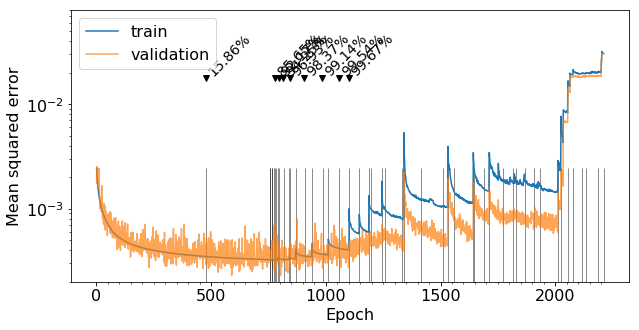

In [33]:
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)


for vline in vlines:
    plt.vlines(vline+1, ymin = 0, ymax = historyDict["mean_squared_error"][0], alpha = 0.5, linewidth = 0.9)

plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [0,7,9, 10,12, 14,16,18, 19]:
    s = str(np.round(cutPercent[jj+1]*2, 2)) + "%"
    plt.plot(vlines[jj], 10**-1.75, "v", color = "black")
    plt.text(vlines[jj], 10**-1.75, s,{'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
plt.show()

In [61]:
## Reload model with 80% of connections pruned and evaluate error

In [62]:
K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06572_Pruned"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName + ".h5"))

## Pruning with Tensorflow Model Optimization Toolkit

### Pruning fixed amount all at once
(rather than the sequential pruning above)

In [30]:
from tensorflow.keras.models import load_model

In [31]:
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_13__01_38_55'

In [32]:
import tensorflow_model_optimization as tfmot

import tempfile
import os

In [37]:
K.clear_session()

modelName = 'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_07_13__01_38_55'
modeltimestamp = "2020_07_13__01_38_55"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

In [38]:
model

In [39]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

In [40]:
def define_pruning_params(percent_pruned):
    '''
    '''
    
    pruning_params = {
        'pruning_schedule': ConstantSparsity(percent_pruned,0),
        'block_size': (1,1),
        'block_pooling_type': 'AVG'
    }
    
    return(pruning_params)

In [41]:
def create_pruned_model(model, 
                        pruning_params,
                        optimizer = 'rmsprop'):

    '''
    '''
    
    pruned_model = prune_low_magnitude(model, **pruning_params)
    
    pruned_model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])
    
    return(pruned_model)

In [42]:
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
]

In [43]:
pruning_params = define_pruning_params(0.90)
pruned_model = create_pruned_model(model, pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.




In [44]:
pruned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 400)               8402      
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 16)                12818     
_________________________________________________________________
prune_low_magnitude_dense_4  (None, 7)                 233       
Total params: 662,257
Trainable params: 331,735
Non-trainable params: 330,522
_________________________________________________

In [45]:
pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=2**12, epochs = 100)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 - 1s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0603 - val_mean_squared_error: 0.0603
Epoch 2/100
8000/8000 - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 3/100
8000/8000 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 4/100
8000/8000 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 5/100
8000/8000 - 0s - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 6/100
8000/8000 - 0s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 7/100
8000/8000 - 0s - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 8/100
8000/8000 - 0s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0365 -

Epoch 65/100
8000/8000 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 66/100
8000/8000 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 67/100
8000/8000 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 68/100
8000/8000 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 69/100
8000/8000 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 70/100
8000/8000 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 71/100
8000/8000 - 0s - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 72/100
8000/8000 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 73

In [46]:
historyDict["mean_squared_error"].extend(pruned_history.history['mean_squared_error'])
historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mean_squared_error'])

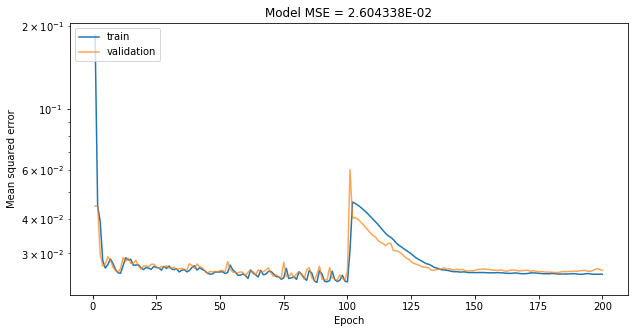

In [47]:
plot_model_history_fromDict(historyDict)

In [63]:
wts = model.get_weights()
# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

63844 of 331735 weights retained


In [64]:
1 - nzwts / np.sum(wtLengths)

0.8075451791339473

In [65]:
numCuts = 7

cutPercent[numCuts]*2

80.75689165786144

In [66]:
for ii in range(10):
    history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                        verbose = 2, batch_size=2**12, epochs = 1)

    # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
    # get nonzero weights
    wts = model.get_weights().copy()

    # set weights close to 0 to 0 (but ignore biases)
    for ii in np.arange(0, len(wts), 1):
        qants = np.percentile(np.reshape(wts[ii], -1), 
                              q = (50 - cutPercent[numCuts], 
                                   50 + cutPercent[numCuts]), )
        wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

    # print nonzero weights
    # calculate number of nonzero weights
    nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
    print(nzwts, "of", np.sum(wtLengths), "weights retained")

    # set new weights and calculate new loss
    model.set_weights(wts)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.5564e-04 - mean_squared_error: 3.5564e-04 - val_loss: 3.5079e-04 - val_mean_squared_error: 3.5079e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5554e-04 - mean_squared_error: 3.5554e-04 - val_loss: 3.6186e-04 - val_mean_squared_error: 3.6186e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5530e-04 - mean_squared_error: 3.5530e-04 - val_loss: 3.6601e-04 - val_mean_squared_error: 3.6601e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5575e-04 - mean_squared_error: 3.5575e-04 - val_loss: 2.5863e-04 - val_mean_squared_error: 2.5863e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5517e-04 - mean_squared_error: 3.5517e-04 - val_loss: 4

In [67]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 59s 30us/step


[0.0009208869594410062, 0.0009208869594410062]

In [68]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 247s 31us/step


[0.0009208033409710042, 0.0009208033409710042]

In [69]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-5967.453613,17690.990234,-48919.882812,-580.231506,-1343.035034,-114.036430,-118.226456
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-5309.352539,5041.308105,-60412.925781,-1.199094,1383.986938,-4.115515,-8.734145
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-10475.754883,-16107.546875,-47557.539062,-1136.972900,-1391.377197,144.275894,139.078659
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,22148.250000,-6499.242676,67265.007812,-273.286438,-550.424805,135.582123,130.418793
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,3927.504150,6896.766113,32134.501953,647.107727,-55.471333,9.455336,4.783791


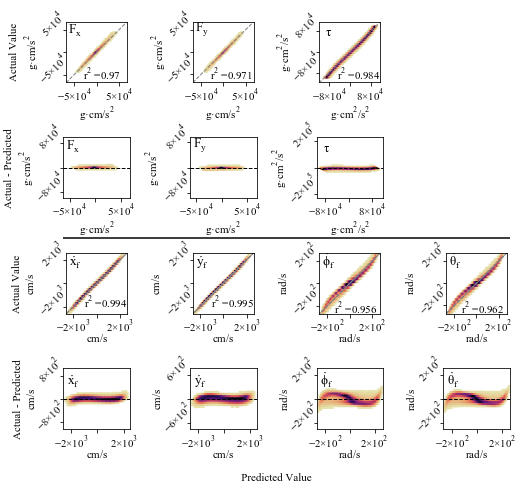

In [70]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()

In [71]:
np.max(df_c.loc[:,"Fy"] - df_c.loc[:,"Fy_pred"])

90125.91557855174

In [72]:
np.max( df_c.loc[:,"Fy_pred"])

68017.96

In [73]:
np.max( df_c.loc[:,"Fy"])

44299.234220458886

In [4]:
print(tf.__version__)

1.13.1
